![Banner](https://raw.githubusercontent.com/crunchdao/quickstarters/refs/heads/master/competitions/broad-3/assets/banner.webp)

## **Autoimmune Disease Machine Learning Crunch #3**

## Quickstarter: Gene Ranking for colon tissue using logFC method

This is an example submission and can be used as a starting point, but should not be seen as the only way to approach the problem. However, this approach can be improved in many ways.

This notebook addresses the task of **ranking genes** to identify **pre-cancerous tissue regions** in the context of inflammatory bowel disease (IBD). The goal is to rank **18 615 genes** based on their ability to distinguish dysplastic (pre-cancerous) from non-cancerous mucosa regions in colon tissue samples.

The solution follows a three-step process:

* **Crunch 1: Predict the Expression of 460 Measured Genes**: This step uses a **ResNet50 embedding model and regression models**, trained on H&E pathology images, to predict the expression of 460 genes for each cell in the dataset.

* **Crunch 2: Predict the Expression of 18157 Unmeasured Genes**: Leveraging the predictions from Crunch 1 and a **single-cell RNA sequencing (scRNA-Seq)** reference dataset, a **similarity-based method** is applied to infer the expression of 18157 unmeasured genes for each cell in the dataset.

* **Crunch 3: Gene Ranking Using logFC Method**: In this step, we apply the **log fold change (logFC)** method to rank genes based on their ability to differentiate between dysplastic and non-dysplastic tissue regions. The logFC method computes the logarithmic fold change between the predicted expression values for the two regions (dysplastic and non-dysplastic). Genes are ranked based on the magnitude of their logFC values, with higher values indicating greater differentiation potential between the regions. For a detailed explanation of the logFC method, please refer to the [logFC explanation document](https://olvtools.com/en/rnaseq/help/fold-change).

> For CrunchDAO Challenge submission, you will need to **pre-download** the gene ranking file (`ranking_gene.csv`) from your local system and submit it along with the notebook.

Most of the code is already used in the [Quickstarter Crunch 1 Resnet50 + Ridge](https://github.com/crunchdao/competitions/blob/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/resnet50-plus-ridge.ipynb) and Quickstarter Crunch 2 Cosine similarity. For more details on the methodology and implementation, refer to these notebooks.

The added sections are:

* **A Sandbox Example for the BROAD 3 Challenge**
* **A function to apply gene ranking**
* **Train: a function to apply Crunch 1, Crunch 2 and gene ranking from UC9_I-crunch3 sample**

Note: This notebook is still designed to run seamlessly on a **CPU** environment.

## **SHORT EXAMPLE**

Short example to help you understand both the road 3 crunch problem and the technique used to address it:

![gene_ranking_short_example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-3/quickstarters/log-fc/images/gene_ranking_short_example.png)

`Identifying gene markers of pre-cancerous tisue regions in IBD (Crunch 3)`

![crunch_3_challenge](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-3/quickstarters/log-fc/images/crunch_3_challenge.png)

You need a **token** to load the dataset of the challenge.

Get a new token: https://hub.crunchdao.com/competitions/broad-3/submit/via/notebook

In [1]:
!pip install crunch-cli --upgrade
!crunch setup --size default broad-3 catskills --token paUxd4z3n2t0oZfeTTpBFTvrYktBrhcsBCLYsIAb8guwlcaOBAe9IGMFinFG5lF7
!cd broad-3-catskills

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
main.py: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/20496/main.py (59325 bytes)
notebook.ipynb: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/20496/notebook.ipynb (360680 bytes)
REPORT.md: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/20496/REPORT.md (4172 bytes)
requirements.txt: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/submissions/20496/requirements.original.txt (262 bytes)
data/UC9_I-crunch3-HE-label-stardist.tif: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/98/UC9_I-crunch3-HE-label-stardist.tif (23778030 bytes)
data/Crunch3_gene_list.csv: download from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/98/Crunch3_gene_list.csv (122177 bytes)
da

## Imports

In [2]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


In [3]:
%pip install numpy pandas torch scipy openslide-python pydantic pytorch-lightning dask distributed matplotlib seaborn scikit-learn==1.5.2 opencv-python scanpy spatialdata zarr ome-zarr

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 15.7 MB/s eta 0:00:00 MB/s eta 0:00:0101
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
Note: you may need to restart the kernel to use updated packages.


## A Sandbox Example for the Broad 3 Challenge

This short example will help you understand both the Broad 3 challenge problem and the technique used to address it:

**Problem statement: Identify the most discriminative genes that distinguish dysplasia (pre-cancerous) from non-cancerous tissue regions using log Fold Change (logFC).**

Gene expression data for non-cancerous cells (n_cells x 18615 genes), example representation:


,Gene A,Gene B,Gene C
Cell no_cancer 1,2.1,3.0,0.5
Cell no_cancer 2,1.8,2.7,0.4
Cell no_cancer 3,2.2,3.2,0.6



Gene expression data for pre-cancerous cells (m_cells x 18615 genes), example representation:


,Gene A,Gene B,Gene C
Cell cancer 1,4.0,1.2,0.3
Cell cancer 2,3.8,1.5,0.2
Cell cancer 3,4.2,1.3,0.4



**Compute log Fold Change (logFC):**

Gene ranking based on absolute logFC:


,Gene,Mean No Cancer,Mean Cancer,Variance No Cancer,Variance Cancer,Difference Mean,logFC,abs_logFC
1,Gene B,2.97,1.33,0.06,0.02,1.63,-1.15,1.15
0,Gene A,2.03,4.00,0.04,0.04,1.97,0.98,0.98
2,Gene C,0.50,0.30,0.01,0.01,0.20,-0.74,0.74


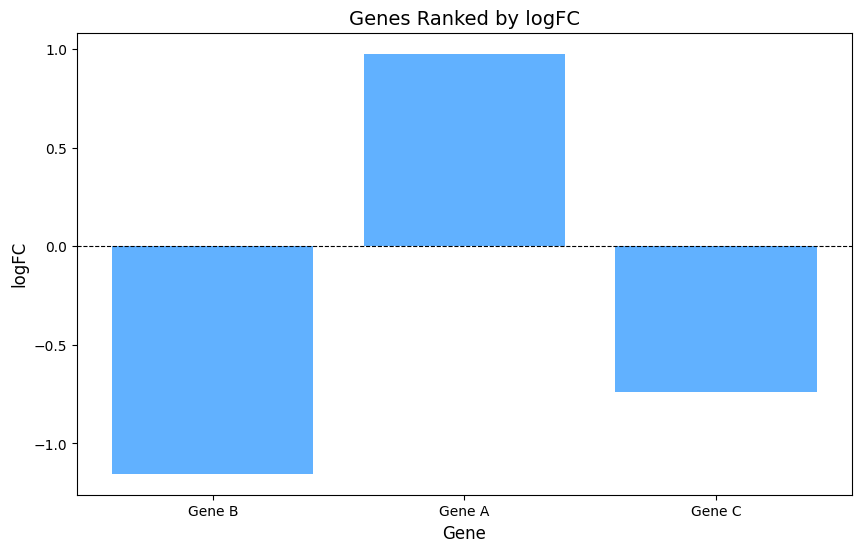

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("**Problem statement: Identify the most discriminative genes that distinguish dysplasia (pre-cancerous) from non-cancerous tissue regions using log Fold Change (logFC).**\n")

# Examples
prediction_cell_ids_no_cancer = pd.DataFrame(
    [[2.1, 3.0, 0.5], [1.8, 2.7, 0.4], [2.2, 3.2, 0.6]],
    columns=["Gene A", "Gene B", "Gene C"],
    index=["Cell no_cancer 1", "Cell no_cancer 2", "Cell no_cancer 3"]
)

prediction_cell_ids_cancer = pd.DataFrame(
    [[4.0, 1.2, 0.3], [3.8, 1.5, 0.2], [4.2, 1.3, 0.4]],
    columns=["Gene A", "Gene B", "Gene C"],
    index=["Cell cancer 1", "Cell cancer 2", "Cell cancer 3"]
)

print("Gene expression data for non-cancerous cells (n_cells x 18615 genes), example representation:")
display(prediction_cell_ids_no_cancer)
print("\nGene expression data for pre-cancerous cells (m_cells x 18615 genes), example representation:")
display(prediction_cell_ids_cancer)

print("\n**Compute log Fold Change (logFC):**\n")

# Means
mean_no_cancer = prediction_cell_ids_no_cancer.mean(axis=0)
mean_cancer = prediction_cell_ids_cancer.mean(axis=0)

# Log Fold Change
# From: https://olvtools.com/en/rnaseq/help/fold-change
epsilon = 1e-6  # To avoid division by zero
log_fc = np.log2((mean_cancer + epsilon) / (mean_no_cancer + epsilon))

# Variance
var_no_cancer = prediction_cell_ids_no_cancer.var(axis=0)
var_cancer = prediction_cell_ids_cancer.var(axis=0)

# Means difference
dif_abs_mean = np.abs(mean_no_cancer - mean_cancer)

gene_ranking_df = pd.DataFrame({
    "Gene": prediction_cell_ids_no_cancer.columns,
    "Mean No Cancer": mean_no_cancer.values,
    "Mean Cancer": mean_cancer.values,
    "Variance No Cancer": var_no_cancer.values,
    "Variance Cancer": var_cancer.values,
    "Difference Mean": dif_abs_mean.values,
    "logFC": log_fc.values
})

# Sort by absolute logFC
gene_ranking_df['abs_logFC'] = gene_ranking_df['logFC'].abs()
gene_ranking_df = gene_ranking_df.sort_values(by='abs_logFC', ascending=False)

print("Gene ranking based on absolute logFC:")
display(round(gene_ranking_df, 2))

plt.figure(figsize=(10, 6))
plt.bar(gene_ranking_df['Gene'], gene_ranking_df['logFC'], color='dodgerblue', alpha=0.7)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title(f"Genes Ranked by logFC", fontsize=14)
plt.ylabel("logFC", fontsize=12)
plt.xlabel("Gene", fontsize=12)
plt.show()

In [5]:
# Import libraries
# Core Python Libraries
import os
import json
import warnings
import gc
import joblib
from types import SimpleNamespace
from abc import abstractmethod
from tqdm import tqdm
import random
import psutil

# Core Data manipulation Libraries
import numpy as np
import pandas as pd

# Visualization Library
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Spatial Data Processing
import spatialdata as sd  # Manage multi-modal spatial omics datasets
import anndata as ad  # Manage annotated data matrices in memory and on disk
import scanpy as sc  # For analyzing single-cell data, especially for dimensionality reduction and clustering.
from skimage.measure import regionprops  # Get region properties of nucleus/cell image from masked nucleus image
import h5py  # For handling HDF5 data files
import skimage.io

# Frameworks for ML and DL models
import torch
import timm  # timm: A library to load pretrained SOTA computer vision models (e.g. classification, feature extraction, ...)

import warnings
warnings.filterwarnings("ignore", message="ignoring keyword argument 'read_only'")

/home/catskills/Desktop/broad/broad/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## Utilities for Saving and Reading HDF5 Files

This section contains functions for efficiently saving and loading data from HDF5 files, which is a common format for storing large datasets.

* `save_hdf5` & `read_assets_from_h5`: Functions for saving and reading datasets and attributes to/from HDF5 files.
* `Patcher` class: Extracts image patches from a larger image using given coordinates.

![patcher](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/patcher.png)

In [6]:
#####
#  Utilities for saving and reading HDF5 files
####

def save_hdf5(output_fpath, asset_dict, attr_dict=None, mode='a', auto_chunk=True, chunk_size=None):
    """
    Save data and attributes into an HDF5 file, or initialize a new file with the given data.

    Parameters:
        output_fpath (str): Path to save the HDF5 file.
        asset_dict (dict): Dictionary containing keys and their corresponding data (e.g., numpy arrays) to save.
        attr_dict (dict, optional): Dictionary of attributes for each key. Format: {key: {attr_key: attr_val, ...}}.
        mode (str): File mode ('a' for append, 'w' for write, etc.).
        auto_chunk (bool): Whether to enable automatic chunking for HDF5 datasets.
        chunk_size (int, optional): If auto_chunk is False, specify the chunk size for the first dimension.

    Returns:
        str: Path of the saved HDF5 file.
    """

    with h5py.File(output_fpath, mode) as f:
        for key, val in asset_dict.items():
            data_shape = val.shape
            # Ensure data has at least 2 dimensions
            if len(data_shape) == 1:
                val = np.expand_dims(val, axis=1)
                data_shape = val.shape

            if key not in f:  # if key does not exist, create a new dataset
                data_type = val.dtype

                if data_type.kind == 'U':  # Handle Unicode strings
                    chunks = (1, 1)
                    max_shape = (None, 1)
                    data_type = h5py.string_dtype(encoding='utf-8')
                else:
                    if data_type == np.object_:
                        data_type = h5py.string_dtype(encoding='utf-8')
                    # Determine chunking strategy
                    if auto_chunk:
                        chunks = True  # let h5py decide chunk size
                    else:
                        chunks = (chunk_size,) + data_shape[1:]
                    maxshape = (None,) + data_shape[1:]  # Allow unlimited size for the first dimension

                try:
                    dset = f.create_dataset(key,
                                            shape=data_shape,
                                            chunks=chunks,
                                            maxshape=maxshape,
                                            dtype=data_type)
                    # Save attributes for the dataset
                    if attr_dict is not None:
                        if key in attr_dict.keys():
                            for attr_key, attr_val in attr_dict[key].items():
                                dset.attrs[attr_key] = attr_val
                    # Write the data to the dataset
                    dset[:] = val
                except:
                    print(f"Error encoding {key} of dtype {data_type} into hdf5")

            else:  # Append data to an existing dataset
                dset = f[key]
                dset.resize(len(dset) + data_shape[0], axis=0)
                # assert dset.dtype == val.dtype
                dset[-data_shape[0]:] = val

    return output_fpath


def read_assets_from_h5(h5_path, keys=None, skip_attrs=False, skip_assets=False):
    """
    Read data and attributes from an HDF5 file.

    Parameters:
        h5_path (str): Path to the HDF5 file.
        keys (list, optional): List of keys to read. Reads all keys if None.
        skip_attrs (bool): If True, skip reading attributes.
        skip_assets (bool): If True, skip reading data assets.

    Returns:
        tuple: A dictionary of data assets and a dictionary of attributes.
    """

    assets = {}
    attrs = {}
    with h5py.File(h5_path, 'r') as f:
        if keys is None:
            keys = list(f.keys())

        for key in keys:
            if not skip_assets:
                assets[key] = f[key][:]
            if not skip_attrs and f[key].attrs is not None:
                attrs[key] = dict(f[key].attrs)

    return assets, attrs


class Patcher:

    def __init__(self, image, coords, patch_size_target, name=None):
        """
        Initializes the patcher object to extract patches (localized square sub-region of an image) from an image at specified coordinates.

        :param image: Input image as a numpy array (H x W x 3), the input image from which patches will be extracted.
        :param coords: List or array of cell coordinates (centroïd) [(x1, y1), (x2, y2), ...].
        :param patch_size_target: Target size of patches.
        :param name: Name of the whole slide image (optional).
        """

        self.image = image
        self.height, self.width = image.shape[:2]
        self.coords = coords
        self.patch_size_target = patch_size_target
        self.name = name

    def __iter__(self):
        """
        Iterates over coordinates, yielding image patches and their coordinates.
        """

        for x, y in self.coords:
            # Extract patch dimension centered at (x, y)
            x_start = max(x - self.patch_size_target // 2, 0)
            y_start = max(y - self.patch_size_target // 2, 0)
            x_end = min(x_start + self.patch_size_target, self.width)
            y_end = min(y_start + self.patch_size_target, self.height)

            # Ensure the patch size matches the target size, padding with zeros if necessary
            patch = np.zeros((self.patch_size_target, self.patch_size_target, 3), dtype=np.uint8)
            patch[:y_end - y_start, :x_end - x_start, :] = self.image[y_start:y_end, x_start:x_end, :]

            yield patch, x, y

    def __len__(self):
        """
        Returns the number of patches based on the number of coordinates.
        This is used to determine how many iterations will be done when iterating over the object.
        """

        return len(self.coords)

    def save_visualization(self, path, vis_width=300, dpi=150):
        """
        Save a visualization of patches overlayed on the tissue H&E image.
        This function creates a plot where each patch's location is marked with a rectangle overlaid on the image.

        :param path: File path where the visualization will be saved.
        :param vis_width: Target width of the visualization in pixels.
        :param dpi: Resolution of the saved visualization.
        """

        # Generate the tissue visualization mask
        mask_plot = self.image

        # Calculate downscale factor for visualization
        downscale_vis = vis_width / self.width

        # Create a plot
        _, ax = plt.subplots(figsize=(self.height / self.width * vis_width / dpi, vis_width / dpi))
        ax.imshow(mask_plot)

        # Add patches
        patch_rectangles = []
        for x, y in self.coords:
            x_start, y_start = x - self.patch_size_target // 2, y - self.patch_size_target // 2
            patch_rectangles.append(Rectangle((x_start, y_start), self.patch_size_target, self.patch_size_target))

        # Add rectangles to the plot
        ax.add_collection(PatchCollection(patch_rectangles, facecolor='none', edgecolor='black', linewidth=0.3))

        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig(path, dpi=dpi, bbox_inches='tight')
        plt.show()
        plt.close()

    def view_coord_points(self, vis_width=300, dpi=150):
        """
        Visualizes the coordinates as small points in 2D.
        This function generates a scatter plot of the patch coordinates on the H&E image.
        """

        # Calculate downscale factor for visualization
        downscale_vis = vis_width / self.width

        # Create a plot
        _, ax = plt.subplots(figsize=(self.height / self.width * vis_width / dpi, vis_width / dpi))
        plt.scatter(self.coords[:, 0], -self.coords[:, 1], s=0.2)
        plt.show()
        plt.close()

    def to_h5(self, path, extra_assets={}):
        """
        Saves the extracted patches and their associated information to an HDF5 file.

        Each patch is saved as a dataset along with its coordinates and any additional assets (extra_assets).
        The HDF5 file is structured with a dataset for the image patch ('img') and coordinates ('coords').

        :param path: File path where the HDF5 file will be saved.
        :param extra_assets: Dictionary of additional assets to save (optional). Each value in extra_assets must have the same length as the patches.
        """

        mode_HE = 'w'  # Start with write mode for the first patch
        i = 0

        # Check that the extra_assets match the number of patches
        if extra_assets:
            for _, value in extra_assets.items():
                if len(value) != len(self):
                    raise ValueError("Each value in extra_assets must have the same length as the patcher object.")

        # Ensure the file has the correct extension
        if not (path.endswith('.h5') or path.endswith('.h5ad')):
            path = path + '.h5'

        # Loop through each patch and save it to the HDF5 file (loop through __iter__ function)
        for tile, x, y in tqdm(self):
            assert tile.shape == (self.patch_size_target, self.patch_size_target, 3)

            # Prepare the data to be saved for this patch
            asset_dict = {
                'img': np.expand_dims(tile, axis=0),  # Shape (1, h, w, 3)
                'coords': np.expand_dims([x, y], axis=0)  # Shape (1, 2)
            }

            # Add any extra assets to the asset dictionary
            extra_asset_dict = {key: np.expand_dims([value[i]], axis=0) for key, value in extra_assets.items()}
            asset_dict = {**asset_dict, **extra_asset_dict}

            # Define the attributes for the image patch
            attr_dict = {'img': {'patch_size_target': self.patch_size_target}}

            if self.name is not None:
                attr_dict['img']['name'] = self.name

            # Save the patch data to the HDF5 file
            save_hdf5(path, asset_dict, attr_dict, mode=mode_HE, auto_chunk=False, chunk_size=1)
            mode_HE = 'a'  # Switch to append mode after the first patch
            i += 1

## Preprocessing Spatial Transcriptomics Data

This section contains functions for preprocessing spatial transcriptomics data, including extracting spatial coordinates, generating image patches and preparing datasets for training and testing.

* **`extract_spatial_positions`**: Extracts spatial coordinates (centroids) of cells.
* **`process_and_visualize_image`**: Extracts square image patches from H&E images and visualizes them.
* **`preprocess_spatial_transcriptomics_data_train`**: Prepares training data by generating gene expression (Y) and image patch datasets (X).
* **`preprocess_spatial_transcriptomics_data_test`**: Prepares test data by generating image patches (X) for selected cells.
* **`create_cross_validation_splits`**: Creates leave-one-out cross-validation splits for model evaluation.

![data_X_Y](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/data_X_Y.png)

`Leave-one-out cross-validation schema:`
![cross_validation](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/cross_validation.png)

In [7]:
##########
# Preprocessing spatial transcriptomics data
##########

def extract_spatial_positions(sdata, cell_id_list):
    """
    Extracts spatial positions (centroids) of regions from the nucleus image where cell IDs match the provided cell list.

    Need to use 'HE_nuc_original' to extract spatial coordinate of cells
    HE_nuc_original: The nucleus segmentation mask of H&E image, in H&E native coordinate system. The cell_id in this segmentation mask matches with the nuclei by gene matrix stored in anucleus.
    HE_nuc_original is like a binary segmentation mask 0 - 1 but replace 1 with cell_ids.
    You can directly find the location of a cell, with cell_id, through HE_nuc_original==cell_id

    Parameters:
    -----------
    sdata: SpatialData
        A spatial data object containing the nucleus segmentation mask ('HE_nuc_original').
    cell_id_list: array-like
        A list or array of cell IDs to filter the regions.

    Returns:
    --------
    np.ndarray
        A NumPy array of spatial coordinates (x_center, y_center) for matched regions.
    """

    print("Extracting spatial positions ...")
    # Get region properties from the nucleus image: for each cell_id get its location on HE image
    if "tif_HE_nuc" in sdata:
        regions = regionprops(sdata['tif_HE_nuc'])
    else:
        regions = regionprops(sdata['HE_nuc_original'][0, :, :].to_numpy())

    dict_spatial_positions = {}
    # Loop through each region and extract centroid if the cell ID matches
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        # Extract only coordinates from the provided cell_id list
        if cell_id in cell_id_list:
            y_center, x_center = int(centroid[0]), int(centroid[1])
            dict_spatial_positions[cell_id] = [x_center, y_center]

    # To maintain cell IDs order
    spatial_positions = []
    for cell_id in cell_id_list:
        try:
            spatial_positions.append(dict_spatial_positions[cell_id])
        except KeyError:
            print(f"Warning: Cell ID {cell_id} not found in the segmentation mask.")
            spatial_positions.append([1000, 1000])

    return np.array(spatial_positions)


def process_and_visualize_image(sdata, patch_save_dir, name_data, coords_center, target_patch_size, barcodes,
                                show_extracted_images=False, vis_width=1000):
    """
    Load and process the spatial image data, creates patches, saves them in an HDF5 file,
    and visualizes the extracted images and spatial coordinates.

    Parameters:
    -----------
    sdata: SpatialData
        A spatial data object containing the image to process ('HE_original') and associated metadata.
    patch_save_dir: str
        Directory where the resulting HDF5 file and visualizations will be saved.
    name_data: str
        Name used for saving the dataset.
    coords_center: array-like
        Coordinates of the regions to be patched (centroids of cell regions).
    target_patch_size: int
        Size of the patches to extract from the image.
    barcodes: array-like
        Barcodes associated with patches.
    show_extracted_images: bool, optional (default=False)
        If True, will show extracted images during the visualization phase.
    vis_width: int, optional (default=1000)
        Width of the visualization images.
    """

    # Load the image and transpose it to the correct format
    print("Loading imgs ...")
    if 'tif_HE' in sdata:
        intensity_image = sdata['tif_HE'].copy()
    else:
        intensity_image = np.transpose(sdata['HE_original'].to_numpy(), (1, 2, 0))

    print("Patching: create image dataset (X) ...")
    # Path for the .h5 image dataset
    h5_path = os.path.join(patch_save_dir, name_data + '.h5')

    # Create the patcher object to extract patches (localized square sub-region of an image) from an image at specified coordinates.
    patcher = Patcher(
        image=intensity_image,
        coords=coords_center,
        patch_size_target=target_patch_size
    )

    # Build and Save patches to an HDF5 file
    patcher.to_h5(h5_path, extra_assets={'barcode': barcodes})

    # Visualization
    print("Visualization")
    if show_extracted_images:
        print("Extracted Images (high time and memory consumption...)")
        patcher.save_visualization(os.path.join(patch_save_dir, name_data + '_viz.png'), vis_width=vis_width)

    print("Spatial coordinates")
    patcher.view_coord_points(vis_width=vis_width)

    # Display some example images from the created dataset
    print("Examples from the created .h5 dataset")
    assets, _ = read_assets_from_h5(h5_path)

    n_images = 3
    fig, axes = plt.subplots(1, n_images, figsize=(15, 5))
    for i in range(n_images):
        axes[i].imshow(assets["img"][i])
    for ax in axes:
        ax.axis('off')
    plt.show()

    # Delete variables that are no longer used
    del intensity_image, patcher, assets
    gc.collect()


def preprocess_spatial_transcriptomics_data_test(name_data, sdata, cell_id_list, dir_processed_dataset, target_patch_size=32, vis_width=1000, show_extracted_images=False):
    """
    Test step: Preprocesses spatial transcriptomics data by performing the following steps for the selected ST data:
    1. Extract spatial coordinates of the selected cells.
    2. Generates and saves patches of images centered on spatial coordinates to HDF5 files (X) into directory 'patches'.

    Parameters:
    -----------
    name_data: str
        Name used for saving the dataset.
    sdata: SpatialData
        A spatial data object containing the image to process ('HE_original') and associated metadata.
    cell_id_list : array-like
        A list or array of cell IDs to filter the regions.
    dir_processed_dataset: str
        Path to the directory where processed datasets and outputs will be saved.
    target_patch_size: int, optional
        Target size of image patches to extract.
    vis_width: int, optional
        Width of the visualization output for spatial and image patches.
    show_extracted_images: bool
    """

    # Creates directories for saving patches ('patches')
    patch_save_dir = os.path.join(dir_processed_dataset, "patches")
    os.makedirs(patch_save_dir, exist_ok=True)

    print("\n -- PREPROCESS SPATIAL TRANSCRIPTOMICS DATASET --------------------------------------------\n")

    # Extract spatial positions for selected cells
    new_spatial_coord = extract_spatial_positions(sdata, cell_id_list)

    # Spatial coordinates and barcodes (cell IDs) for the patches
    coords_center = new_spatial_coord
    barcodes = np.array(['x' + str(i).zfill(6) for i in list(cell_id_list)])  # Trick to set all index to same length to avoid problems when saving to h5

    # Generate and visualize image patches centered around spatial coordinates ({name_data}.h5 file in directory os.path.join(dir_processed_dataset, "patches"))
    process_and_visualize_image(sdata, patch_save_dir, name_data, coords_center, target_patch_size, barcodes,
                                show_extracted_images=False, vis_width=1000)

    print("\nPreprocess dataset DONE\n")

## Encoder functions

Provide the structure for building and utilizing pre-trained models specifically designed for extracting features from images.

In [8]:
##########
# Encoder functions
##########

from torchvision import transforms
import torchvision.transforms.functional as TF


class InferenceEncoder(torch.nn.Module):
    """
    Abstract base class for building inference encoders.

    Attributes:
    -----------
    weights_path : str or None
        Path to the model weights (optional).
    model : torch.nn.Module
        The model architecture.
    eval_transforms : callable
        Evaluation transformations applied to the input images.
    precision : torch.dtype
        The data type of the model's parameters and inputs.
    """

    def __init__(self, weights_path=None, **build_kwargs):
        super(InferenceEncoder, self).__init__()

        self.weights_path = weights_path
        self.model, self.eval_transforms, self.precision = self._build(weights_path, **build_kwargs)

    def forward(self, x):
        z = self.model(x)
        return z

    @abstractmethod
    def _build(self, **build_kwargs):
        pass


def get_eval_transforms(mean, std):
    """
    Creates the evaluation transformations for preprocessing images. This includes
    converting the images to tensor format and normalizing them with given mean and std.

    Parameters:
    -----------
    mean : list
        The mean values used for normalization.
    std : list
        The standard deviation values used for normalization.

    Returns:
    --------
    transforms.Compose
        A composed transformation function that applies the transformations in sequence.
    """

    trsforms = []

    # Convert image to tensor
    trsforms.append(lambda img: TF.to_tensor(img))

    if mean is not None and std is not None:
        # Normalize the image
        trsforms.append(lambda img: TF.normalize(img, mean, std))

    return transforms.Compose(trsforms)


class ResNet50InferenceEncoder(InferenceEncoder):
    """
    A specific implementation of the InferenceEncoder class for ResNet50.
    This encoder is used to extract features from images using a pretrained ResNet50 model.
    """

    def _build(
        self,
        weights_root="resnet50.tv_in1k",
        timm_kwargs={"features_only": True, "out_indices": [3], "num_classes": 0},
        pool=True
    ):
        """
        Build the ResNet50 model and load its weights. It supports both pretrained models
        from the internet and pretrained models from a given weights path (offline).

        Parameters:
        -----------
        weights_root : str
            Path to pretrained model weights. Defaults to "resnet50.tv_in1k" (if online).
        timm_kwargs : dict
            Additional arguments for creating the ResNet50 model via the timm library.
        pool : bool
            Whether to apply adaptive average pooling to the output of the model. Defaults to True.

        Returns:
        --------
        tuple
            A tuple containing the ResNet50 model, the evaluation transformations and the precision type.
        """

        if weights_root == "resnet50.tv_in1k":
            pretrained = True
            print("Load pretrained Resnet50 from internet")
        else:
            pretrained = False
            print(f"Load pretrained Resnet50 offline from weights path: {weights_root}")

        # Build the model using the timm library
        model = timm.create_model("resnet50.tv_in1k", pretrained=pretrained, **timm_kwargs)

        # If not using a pretrained model, load weights from the specified path
        if not pretrained and os.path.exists(weights_root):
            # Load the weights
            checkpoint = torch.load(weights_root, map_location='cpu', weights_only=True)  # or 'cuda' if using GPU

            # Remove the classifier layers from the checkpoint
            model_state_dict = model.state_dict()
            checkpoint = {k: v for k, v in checkpoint.items() if k in model_state_dict}

            # Load the weights into the model
            model.load_state_dict(checkpoint, strict=False)
        elif not pretrained:
            # Issue a warning if the weights file is missing
            print(f"\n!!! WARNING: The specified weights file '{weights_root}' does not exist. The model will be initialized with random weights.\n")

        imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        eval_transform = get_eval_transforms(imagenet_mean, imagenet_std)
        precision = torch.float32
        if pool:
            self.pool = torch.nn.AdaptiveAvgPool2d(1)
        else:
            self.pool = None

        return model, eval_transform, precision

    def forward(self, x):
        out = self.forward_features(x)
        if self.pool:
            out = self.pool(out).squeeze(-1).squeeze(-1)
        return out

    def forward_features(self, x):
        out = self.model(x)
        if isinstance(out, list):
            assert len(out) == 1
            out = out[0]
        return out


def inf_encoder_factory(enc_name):
    """
    Factory function to instantiate an encoder based on the specified name.

    Parameters:
    -----------
    enc_name : str
        The name of the encoder model to instantiate (e.g., 'resnet50').

    Returns:
    --------
    class
        The encoder class corresponding to the specified encoder name.
    """

    if enc_name == 'resnet50':
        return ResNet50InferenceEncoder
    else:
        raise ValueError(f"Unknown encoder name {enc_name}")

## Torch Dataset & Embeddings

This section defines a custom torch dataset for handling spatial transcriptomics data and generating embeddings for image patches.

* **`H5Dataset`**: A torch `Dataset` class for loading spatial transcriptomics data from an HDF5 file. It loads image patches, their associated barcodes/cells and coordinates in batches to efficiently handle large datasets.
* **`generate_embeddings`**: A utility for generating embeddings from images  and saving them to an HDF5 file. It handles creating a `DataLoader`, running the model in evaluation mode and saving embeddings to disk.

In [9]:
#########
# Torch Dataset & Embeddings
#########

from torch.utils.data import Dataset


class H5Dataset(Dataset):
    """
    Dataset to read ST + H&E from an HDF5 (.h5) file
    The dataset loads images and their associated barcodes/cells and coordinates in chunks for efficient data handling.

    Attributes:
    -----------
    h5_path : str
        Path to the HDF5 file containing the images, barcodes and coordinates.
    img_transform : callable, optional
        A transformation function to apply to the images. Defaults to None.
    chunk_size : int, optional
        Number of items to load per batch. Defaults to 1000.
    n_chunks : int
        The total number of chunks, calculated based on the size of the 'barcode' array.
    """

    def __init__(self, h5_path, img_transform=None, chunk_size=1000):
        self.h5_path = h5_path
        self.img_transform = img_transform
        self.chunk_size = chunk_size
        with h5py.File(h5_path, 'r') as f:
            self.n_chunks = int(np.ceil(len(f['barcode']) / chunk_size))

    def __len__(self):
        return self.n_chunks

    def __getitem__(self, idx):
        """
        Fetches a batch of data (images, barcodes and coordinates) from the HDF5 file.

        Parameters:
        -----------
        idx : int
            The index of the chunk to fetch.

        Returns:
        --------
        dict
            A dictionary containing the images, barcodes and coordinates for the specified chunk.
        """

        start_idx = idx * self.chunk_size
        end_idx = (idx + 1) * self.chunk_size
        # Open the HDF5 file and load the specific chunk of data
        with h5py.File(self.h5_path, 'r') as f:
            imgs = f['img'][start_idx:end_idx]
            barcodes = f['barcode'][start_idx:end_idx].flatten().tolist()
            coords = f['coords'][start_idx:end_idx]

        # Apply image transformations if any (e.g. to Torch and normalization)
        if self.img_transform:
            imgs = torch.stack([self.img_transform(img) for img in imgs])

        return {'imgs': imgs, 'barcodes': barcodes, 'coords': coords}


def post_collate_fn(batch):
    """ Post collate function to clean up batch """

    if batch["imgs"].dim() == 5:
        assert batch["imgs"].size(0) == 1
        batch["imgs"] = batch["imgs"].squeeze(0)

    if batch["coords"].dim() == 3:
        assert batch["coords"].size(0) == 1
        batch["coords"] = batch["coords"].squeeze(0)

    return batch


def embed_tiles(dataloader, model: torch.nn.Module, embedding_save_path: str, device: str, precision):
    """
    Extracts embeddings from image tiles using the specified model and saves them to an HDF5 file.

    Parameters:
    -----------
    dataloader : torch.utils.data.DataLoader
        DataLoader providing the batches of image tiles.
    model : torch.nn.Module
        The model used to generate embeddings from the tiles.
    embedding_save_path : str
        Path where the generated embeddings will be saved.
    device : str
        The device to run the model on (e.g., 'cuda' or 'cpu').
    precision : torch.dtype
        The precision (data type) to use for inference (e.g., float16 for mixed precision).
    """

    model.eval()
    # Iterate over the batches in the DataLoader
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        batch = post_collate_fn(batch)
        imgs = batch['imgs'].to(device).float()
        # Apply model on images
        with torch.inference_mode():
            if torch.cuda.is_available():  # Use mixed precision only if CUDA is available
                with torch.amp.autocast('cuda', dtype=precision):
                    embeddings = model(imgs)
            else:  # No mixed precision on CPU
                embeddings = model(imgs)

        # Set mode to 'w' for the first batch, 'a' for appending subsequent batches
        mode = 'w' if batch_idx == 0 else 'a'

        # Create a dictionary with embeddings and other relevant data to save
        asset_dict = {'embeddings': embeddings.cpu().numpy()}
        asset_dict.update({key: np.array(val) for key, val in batch.items() if key != 'imgs'})

        # Save the embeddings to the HDF5 file
        save_hdf5(embedding_save_path, asset_dict=asset_dict, mode=mode)

    return embedding_save_path


def generate_embeddings(embed_path, encoder, device, tile_h5_path, batch_size, num_workers, overwrite=False):
    """
    Generate embeddings for images and save to a specified path.

    Parameters:
    -----------
    embed_path : str
        Path to save the embeddings.
    encoder : torch.nn.Module
        The encoder model for generating embeddings.
    device : torch.device
        Device to use for computation (e.g., 'cuda' or 'cpu').
    tile_h5_path : str
        Path to the HDF5 file containing images.
    batch_size : int
        Batch size for the DataLoader.
    num_workers : int
        Number of worker threads for data loading.
    overwrite : bool, optional
        If True, overwrite existing embeddings. Default is False.
    """

    # If the embeddings file doesn't exist or overwrite is True, proceed to generate embeddings
    if not os.path.isfile(embed_path) or overwrite:
        print(f"Generating embeddings for {embed_path} ...")

        # Set encoder to evaluation mode and move it to the device
        encoder.eval()
        encoder.to(device)

        # Create dataset and dataloader for tiles
        tile_dataset = H5Dataset(tile_h5_path, chunk_size=batch_size, img_transform=encoder.eval_transforms)
        tile_dataloader = torch.utils.data.DataLoader(
            tile_dataset,
            batch_size=1,
            shuffle=False,
            num_workers=num_workers
        )

        # Generate and save embeddings
        embed_tiles(tile_dataloader, encoder, embed_path, device, encoder.precision)

        del tile_dataset, tile_dataloader
        gc.collect()
    else:
        print(f"Skipping embedding {os.path.basename(embed_path)} as it already exists")

## Utility functions used in Crunch 1 & 2

In [10]:
##########
# functions for inference (crunch 1)
##########

def embedding_and_load_data(name_data, dir_processed_dataset_test, test_embed_dir, args, device):
    """
    Embedding of the images using the specified encoder and load the resulting data.

    Args:
    - name_data (str): The name of the data to process.
    - dir_processed_dataset_test (str): Directory where the processed test dataset is stored.
    - test_embed_dir (str): Directory where the embeddings should be saved.
    - args (namespace): Arguments object containing parameters like encoder, batch_size, etc.
    - device (torch.device): The device (CPU or GPU) to perform computations on.

    Returns:
    - assets (dict): Dictionary containing the 'barcodes', 'coords' and 'embeddings' from the embedded data.
    """

    # Print the encoder being used
    print(f"Embedding images using {args.encoder} encoder")

    # Create encoder based on the specified model and load its weights
    encoder = inf_encoder_factory(args.encoder)(args.weights_root)

    # Define the path for the patches data (h5 file)
    tile_h5_path = os.path.join(dir_processed_dataset_test, "patches", f'{name_data}.h5')

    # Check if the file exists
    assert os.path.isfile(tile_h5_path), f"Patches h5 file not found at {tile_h5_path}"

    # Define the embedding output path
    embed_path = os.path.join(test_embed_dir, f'{name_data}.h5')

    # Generate the embeddings and save them to the defined path
    generate_embeddings(embed_path, encoder, device, tile_h5_path, args.batch_size, args.num_workers, overwrite=args.overwrite)

    # Load the embeddings and related assets
    assets, _ = read_assets_from_h5(embed_path)

    # Extract cell IDs and convert to a list of strings
    # The cell IDs are not necessary because the images are kept in the same order as the gene expression data
    cell_ids = assets['barcodes'].flatten().astype(str).tolist()

    del encoder
    gc.collect()

    return assets


def load_models_from_directories(base_path):  # Updated
    """
    Load all trained regression models (one model for each cross-validation split)
    Load 'model.pkl' from each directory within the base_path.

    :param base_path: The parent directory containing split subdirectories.
    :return: A dictionary where keys are directory names and values are the loaded models.
    """

    models = {}
    for name in os.listdir(base_path):
        model_path = os.path.join(base_path, name)
        if model_path.endswith(".pkl"):
            models[name] = joblib.load(model_path)
            print(f"Loaded model from {model_path}")
    if len(models) == 0:
        print(f"NO .pkl MODEL FOUND IN {base_path}. A RANDOM PREDICTION WILL BE PERFORMED !")
    return models


def predict_and_aggregate_models(X_test, results_dir, gene_460_names):
    """
    Load models from the given directory, make predictions on the test set (X_test),
    aggregate the predictions by averaging and set negative predictions to 0.

    Args:
    - X_test (np.array): The test data to make predictions on.
    - results_dir (str): Directory containing the saved models.
    - gene_460_names (list): List of gene names to predict

    Returns:
    - np.array: The aggregated predictions.
    """

    # Load models from the specified directory
    models = load_models_from_directories(results_dir)

    if len(models) == 0:
        # random predictions if no model found
        return np.random.rand(len(X_test), len(gene_460_names))

    # Initialize a list to store predictions
    predictions = []

    # Iterate through each model and make predictions
    for split_name in models.keys():
        preds = models[split_name].predict(X_test)
        predictions.append(preds)

    # Stack the predictions into a 2D array (models x samples)
    predictions = np.stack(predictions)

    # Aggregate predictions by calculating the mean across all models
    average_predictions = np.mean(predictions, axis=0)

    # Set any negative predictions to 0
    average_predictions = np.where(average_predictions < 0, 0.0, average_predictions)

    del models

    return average_predictions


def print_memory_usage(label):
    mem = psutil.virtual_memory()
    print(f"({label}: Total={mem.total/1e9:.2f} GB, Available={mem.available/1e9:.2f} GB, Used={mem.used/1e9:.2f} GB, Percent={mem.percent}%)\n")

In [11]:
##########
# functions for inference (crunch 2)
##########

import torch
import torch.nn.functional as F


def find_matches_cos_similarity(spot_vectors, query_vectors, top_k=1):
    """
    Find the top-k most similar scRNA-Seq cells for each Xenium cell using cosine similarity.

    Args:
        spot_vectors (array): 2D array of gene expression of scRNA-Seq cells.
        query_vectors (array): 2D array of gene expression of Xenium cells.
        top_k (int): Number of top matches to return.

    Returns:
        tuple: Indices and similarity values of top-k matches.
    """

    # Use PyTorch functionalities for efficiency and scalability
    # Normalize the vectors
    spot_vectors = F.normalize(torch.tensor(spot_vectors, dtype=torch.float32), p=2, dim=-1)
    query_vectors = F.normalize(torch.tensor(query_vectors, dtype=torch.float32), p=2, dim=-1)

    # Compute dot product (cosine similarity because vectors are first normalized to unit norm)
    dot_similarity = query_vectors @ spot_vectors.T

    # Find the top_k similar spots for each query
    values, indices = torch.topk(dot_similarity, k=top_k, dim=-1)
    return indices.cpu().numpy(), values.cpu().numpy()


def log1p_normalization_scale_factor(arr, scale_factor=10000):
    row_sums = np.sum(arr, axis=1, keepdims=True)
    row_sums = np.where(row_sums == 0, 1, row_sums)  # Avoid division by zero
    return np.log1p((arr / row_sums) * scale_factor)

## Crunch 1 & 2 Inference function

The `infer_crunch_1` and `infer_crunch_2` functions load locally trained models from your Crunch 1 & 2 works and now perform inference on new datasets.

**Crunch 1:**
1.   Prepare the necessary directories and load the configuration parameters from the previously trained model.
2.   Provide a dataset as a dict containing at least an H&E image of tissue regions (`HE`) and a nuclear segmentation mask (`HE_nuc`).
3.   Preprocess the data into image patches (X_test).
4.   **Load locally `pytorch_model.bin`** in `./resources` to generate embeddings for the dataset
5.   **Load locally the trained regression models** (`config.json` and `.pkl` files from Crunch 1 in `./resources`) to apply regression predictions on the 460 measured genes.

`pytorch_model.bin`, `config.json` and baseline regression model from Crunch 1 quickstarter are available on Hugging Face: https://huggingface.co/Tarandros/Autoimmune_Disease_Machine_Learning_Crunch_1/tree/main (Use your own config file and model if you can)

**Note: You can also manage this Crunch 3 challenge without Crunch 1 & 2: "For those who did not participate in Crunch 1 and 2, you can design
a gene panel from scratch using biological understanding or other approaches."**

![train_architecture](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-1/quickstarters/resnet50-plus-ridge/images/train_architecture.png)

**Crunch 2:**

5.   Apply cosine similarities between predictions and single-cell RNA sequencing from shared genes.
6.   Compute weighted average of unmeasured genes from scRNA-Seq based on similarity scores.
7.   Return the predictions of the 18615 genes (458 shared genes + 18157 unmeasured genes).

![similarity_short_example](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/competitions/broad-2/quickstarters/cosine-similarity/images/similarity_short_example.png)

**Note: You can also manage this Crunch 3 challenge without Crunch 1 & 2: "For those who did not participate in Crunch 1 and 2, you can design
a gene panel from scratch using biological understanding or other approaches."**

In [12]:
def infer_crunch_1(
    name_data: str,  # The name of the dataset being processed (only used for logging and directory naming)
    data_file_path: str,
    model_directory_path: str,  # Path to save the trained model and results
    sdata: dict,  # a dataset as a dict containing at least an H&E image of tissue regions and a nuclear segmentation mask
    cell_ids: list,  # List of cell identifiers to predict gene expression
    gene_460_names: list,  # List of 460 gene names for which predictions will be made
):
    """
    Perform Crunch 1 inference: Predict the expression of 460 genes in spatial transcriptomics data
    using a pre-trained Resnet50 model and regression inference.
    """

    ### Prepare Directories ###
    print(f"\n-- {name_data} INFERENCE ---------------------------------------------------------------\n")

    # Previous Directory to store models and results
    dir_models_and_results = model_directory_path  # updated
    # Load training configuration parameters
    config_path = os.path.join(dir_models_and_results, "config.json")
    with open(config_path, 'r') as f:
        args_dict = json.load(f)
    args = SimpleNamespace(**args_dict)

    args.results_dir = dir_models_and_results  # updated

    # Directory for processed test dataset (temporary storage)
    dir_processed_dataset_test = os.path.join("/tmp", f"processed_dataset_test")
    os.makedirs(dir_processed_dataset_test, exist_ok=True)

    # Directory to store the test data embeddings (temporary storage)
    test_embed_dir = os.path.join(dir_processed_dataset_test, "ST_data_emb")
    os.makedirs(test_embed_dir, exist_ok=True)

    # Set device to GPU if available, else use CPU!!
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ##################################################################
    ##### BROAD Crunch 1: predict the expression of 460 genes #####
    print(f"\n** {name_data} Predict the expression of 460 genes (Crunch 1) ****************************************************************\n")

    ### Preprocess and Embedding Data + Regression inference ###

    # Preprocess the test data for embedding (patch extraction)
    preprocess_spatial_transcriptomics_data_test(name_data, sdata, cell_ids, dir_processed_dataset_test,
                                                 args.target_patch_size, args.vis_width, args.show_extracted_images)

    print(f"\n--{name_data} EMBEDDING--\n")
    # Generate and load the embeddings for the test data
    assets = embedding_and_load_data(name_data, dir_processed_dataset_test, test_embed_dir, args, device)

    # Extract embeddings features for prediction
    X_test = assets["embeddings"]
    print("Embedding shape (X_test):", X_test.shape)

    print(f"\n--{name_data} REGRESSION PREDICTIONS--\n")
    # Make predictions and aggregate results across cross-validation regression models
    average_predictions = predict_and_aggregate_models(X_test, args.results_dir, gene_460_names)

    ### Prepare and Return Predictions ###

    # Convert the predictions to a DataFrame
    prediction_460_genes = pd.DataFrame(np.round(average_predictions, 2), index=cell_ids, columns=gene_460_names)
    print("\n Predictions shape:", prediction_460_genes.shape)

    del average_predictions, X_test, assets
    gc.collect()

    return prediction_460_genes


def infer_crunch_2(
    prediction_460_genes,  # Predicted expression values for 460 genes (Crunch 1 output)
    name_data: str,  # The name of the dataset being processed (only used for logging and directory naming)
    data_file_path: str,
    model_directory_path: str,  # Path to save the trained model and results
    scRNAseq,  # Single-cell RNA sequencing data (AnnData)
    filter_column: str = 'dysplasia',  # Column name used to filter scRNA-seq data
    filter_value: str = 'y'  # Value within the filter column used for filtering
):
    """
    Perform Crunch 2 inference: Predict the expression of 18,157 unmeasured genes in spatial
    transcriptomics data using the expression of the 460 inferred genes and single-cell RNA sequencing data for similarity-based matching.
    """

    ##############################################################################
    ##### BROAD Crunch 2: predict the expression of 18157 unmeasured genes #####
    print(f"\n** {name_data} Predict the expression of 18157 unmeasured genes (Crunch 2) ****************************************************************\n")

    print(f"--COSINE SIMILARITIES between {name_data} and single-cell RNA sequencing from shared genes--\n")

    # Get the 18615 genes to rank
    gene_18615_list = list(scRNAseq.var.index)

    # Extract shared and unmeasured genes
    gene_460 = list(prediction_460_genes.columns)
    common_genes = [g for g in gene_460 if g in gene_18615_list]
    print("Number of shared genes between scRNA-seq and xenium data:", len(common_genes))
    unmeasured_genes = [gene for gene in gene_18615_list if gene not in common_genes]
    print("Number of unmeasured genes in Xenium data:", len(unmeasured_genes), "\n")

    # scRNA-Seq data log1p-normalized with scale factor 10000 on 18615 genes
    rna_data_norm_10000_unmeasured_genes = scRNAseq[:, unmeasured_genes].X.toarray()
    # scRNA-Seq data log1p-normalized with scale factor 100 on 460 genes
    rna_data_norm_100_common_genes = log1p_normalization_scale_factor(scRNAseq[:, common_genes].layers["counts"].toarray(), scale_factor=100)
    print(f"scRNA-Seq data shape ({len(rna_data_norm_100_common_genes)} samples x {scRNAseq.X.shape[1]} shared genes + unmeasured genes)")
    print(f"Xenium data shape ({len(prediction_460_genes)} samples x {len(common_genes)} shared genes)")
    del scRNAseq
    gc.collect()

    print_memory_usage("Before computing cosine similarity")

    # Similarity-Based Matching: Find the top_k most similar spots for each query
    top_k = 30
    print(f"\nCompute COSINE SIMILARITY: Find the top_k(={top_k}) similar scRNA-Seq cells for each Xenium cell...\n")
    matches, similarities = find_matches_cos_similarity(rna_data_norm_100_common_genes, prediction_460_genes[common_genes].values, top_k=top_k)
    del rna_data_norm_100_common_genes
    gc.collect()

    # Weighted Averaging of scRNA-Seq data log1p-normalized with scale factor 10000
    print("Compute WEIGHTED AVERAGE of unmeasured genes from scRNA-Seq based on similarity scores...")
    weighted_avg_df_10000 = pd.DataFrame([
        {
            **dict(zip(unmeasured_genes, np.average(rna_data_norm_10000_unmeasured_genes[indices, :], axis=0, weights=similarity).round(2)))  # updated
        }
        for i, (indices, similarity) in enumerate(zip(matches, similarities))
    ])
    weighted_avg_df_10000.index = prediction_460_genes.index

    # Free memory by deleting large variables and performing garbage collection
    del rna_data_norm_10000_unmeasured_genes, matches, similarities
    gc.collect()

    prediction_18615_genes = pd.concat([prediction_460_genes, weighted_avg_df_10000], axis=1)[gene_18615_list]

    print(f"\n-- {name_data} PREDICTION DONE --\n")

    # Return the final prediction DataFrame
    return prediction_18615_genes

## Crunch 3 Function

The `gene_ranking` function identifies the top discriminating genes that differentiate dysplastic (pre-cancerous) from non-cancerous mucosa regions.

**Steps:**
1. **Input Predictions**: Take gene expression data for non-cancerous and dysplastic cells (shapes: n_cells x 18615genes v.s. m_cells x 18615genes).
2. **Compute Metrics**: Calculate mean, variance and absolute log fold change (logFC) for all 18 615 protein-coding genes.
3. **Rank Genes**: Rank genes by their ability to distinguish dysplastic from non-cancerous regions using absolute log fold change.
4. **Output**: Return a DataFrame of gene names ranked from best to worst discriminator.

**Note: The method’s effectiveness heavily relies on the model/method performances in Crunch #1 & Crunch #2 !**

In [13]:
##########
# Gene ranking function (crunch 3)
##########

def gene_ranking(prediction_cell_ids_no_cancer, prediction_cell_ids_cancer,
                 column_for_ranking="abs_logFC", ascending=False):
    """
    Rank all 18,615 protein-coding genes based on their ability to distinguish dysplasia
    from non-cancerous mucosa regions. Each gene is assigned a rank from 1
    (best discriminator) to 18,615 (worst), comparing expression levels between
    non-cancerous and dysplastic tissue cells.

    Parameters:
    prediction_cell_ids_no_cancer: np.ndarray
        Predicted gene expression for cells from non-cancerous regions.
    prediction_cell_ids_cancer: np.ndarray
        Predicted gene expression for cells from dysplastic (pre-cancerous) regions.
    column_for_ranking: str
        Column name used to rank genes (default is "abs_logFC").
    ascending: bool
        Whether to sort in ascending order (default is False).

    Returns:
    pd.DataFrame
        A DataFrame containing gene names ranked by the specified metric.
    """

    # Calculate mean and variance for each gene
    mean_no_cancer = prediction_cell_ids_no_cancer.mean(axis=0)
    mean_cancer = prediction_cell_ids_cancer.mean(axis=0)

    var_no_cancer = prediction_cell_ids_no_cancer.var(axis=0)
    var_cancer = prediction_cell_ids_cancer.var(axis=0)

    ### Compute ranking metrics ###
    # Compute the absolute difference in mean expression levels
    dif_abs_mean = np.abs(mean_no_cancer - mean_cancer)

    # Compute the log fold change (logFC) for each gene
    epsilon = 1e-6  # Small value to avoid division by zero
    log_fc = np.log2((mean_cancer + epsilon) / (mean_no_cancer + epsilon))

    gene_ranking_df = pd.DataFrame({
        'mean_no_cancer': mean_no_cancer,
        'mean_cancer': mean_cancer,
        'variance_no_cancer': var_no_cancer,
        'variance_cancer': var_cancer,
        'dif_abs_mean': dif_abs_mean,
        'logFC': log_fc,
        'abs_logFC': np.abs(log_fc)
    })

    # Sort by column_for_ranking
    gene_ranking_df = gene_ranking_df.sort_values(by=column_for_ranking, ascending=ascending)

    print(f"Gene ranking by {column_for_ranking}:")
    display(gene_ranking_df)

    # Create the final ranked DataFrame with gene names and their ranks
    prediction = pd.DataFrame(
        gene_ranking_df.index,
        index=np.arange(1, len(gene_ranking_df) + 1),
        columns=['Gene Name'],
    )

    return prediction

### Combined Crunches Training Function

The `train` function integrates Crunch 1, Crunch 2 and Crunch 3 workflows to infer gene expression and identify gene markers distinguishing dysplastic (pre-cancerous) from non-cancerous tissue regions from UC9_I-crunch3 sample.

**Key Steps:**
1. **Initialize Directories and Parameters**:
   - Set up paths and sampling sizes.
   - Define ranking parameters for gene discrimination.

2. **Load and Preprocess Data**:
   - Read a spatial data and extract the 460 measured gene names.
   - Load H&E images and segment cells into dysplastic or non-dysplastic groups using ROI masks from UC9_I-crunch3 sample.

3. **Crunch 1 (Gene Expression Prediction)**:
   - Infer expression of 460 measured genes for sampled dysplastic and non-dysplastic cells.

4. **Crunch 2 (Extended Gene Prediction)**:
   - Use scRNAseq data and inferred 460 genes to predict the expression of 18 157 additional genes.

5. **Crunch 3 (Gene Ranking)**:
   - Rank all 18 615 protein-coding genes based on their ability to distinguish dysplastic from non-cancerous tissue.

6. **Save Results**:
   - Save in the specified `model_directory_path` ranked genes to a CSV file for CrunchDAO submission

**Note: During the CrunchDAO submission, there is no need to run the `train` function. Simply, use the `infer` function loading the locally saved `gene_ranking.csv` file.**

In [14]:
# In the training function, users build and train the model to create a gene ranking.
# Your gene ranking must be stored in the `model_directory_path`.
def train(
    data_directory_path: str,  # Path to the input data directory
    model_directory_path: str  # Path to save the trained model and results
):
    print_memory_usage("Start")
    os.makedirs(model_directory_path, exist_ok=True)

    # Parameters
    args_dict = {
        "size_subset_uc9_i": 2000,  # Number of cells to sample for dysplasia analysis - cancer/no-cancer cells for UC9_I-crunch3

        "file_name_scRNAseq": 'Crunch3_scRNAseq.h5ad',  # Filename for scRNAseq data
        "size_subset_scRNAseq": 10000,  # Number of scRNAseq cells to sample
        "filter_column_scRNAseq": "dysplasia",  # Column for filtering scRNAseq data
        "filter_value_no_cancer": "n",  # Filtered column value indicating absence of cancer
        "filter_value_cancer": "y",  # Filtered column value indicating the presence of cancer

        # Parameters for ranking genes
        "column_for_ranking": "abs_logFC",
        "ascending": False
    }
    # Convert the dictionary to a simple namespace for easy access to attributes
    args = SimpleNamespace(**args_dict)

    print("Read xenium data and dysplasia files...")
    # Loading Spatial Data
    # UC9_I.zarr contains H&E Image noncancerous mucosa (already provided in Crunch 1 and Crunch 2)
    sdata = sd.read_zarr(os.path.join(data_directory_path, 'UC9_I.zarr'))
    # Extract the 460 measured gene names from xenium data
    gene_460_names = list(sdata["anucleus"].var.index)
    del sdata
    gc.collect()

    # Load dysplasia-related files
    # These files include:
    # - HE: An H&E image of tissue regions exhibiting dysplasia
    # - HE_nuc: A nuclear segmentation mask
    # - region: An ROI mask indicating dysplastic vs. non-dysplastic regions of the tissue
    #
    # Using these images, you can extract additional spatial features and labels that may
    # be relevant for training or evaluating your model.
    dysplasia_file = {
        # H&E image of tissue with dysplasia
        'tif_HE': os.path.join(data_directory_path, 'UC9_I-crunch3-HE.tif'),

        # Nucleus segmentation of H&E image
        'tif_HE_nuc': os.path.join(data_directory_path, 'UC9_I-crunch3-HE-label-stardist.tif'),

        # Regions in H&E image highlighting dysplasia and non-dysplasia
        'tif_region': os.path.join(data_directory_path, 'UC9_I-crunch3-HE-dysplasia-ROI.tif')
    }
    # Read the dysplasia-related images and store them in a dictionary
    dysplasia_img_list = {}
    for key in dysplasia_file:
        dysplasia_img_list[key] = skimage.io.imread(dysplasia_file[key])

    print_memory_usage("After Reading dysplasia files")

    ##############################################################################
    # Extract cell IDs highlighting dysplasia and non-dysplasia from UC9_I-crunch3-HE
    print(f"\n***********************************************************************************************************************************************************")
    print(f"** Extract cell IDs highlighting dysplasia and non-dysplasia from UC9_I-crunch3-HE ************************************************************************")
    print(f"***********************************************************************************************************************************************************\n")

    # Get region properties from the nucleus segmentation image: for each cell_id get its location on H&E image
    regions = regionprops(dysplasia_img_list['tif_HE_nuc'])

    # Divide cell IDs between dysplasia and non-dysplasia status
    cell_ids_no_cancer, cell_ids_cancer = [], []
    # Loop through each region and extract centroid if the cell ID matches
    for props in tqdm(regions):
        cell_id = props.label
        centroid = props.centroid
        y_center, x_center = int(centroid[0]), int(centroid[1])
        # Using UC9_I-crunch3-HE-dysplasia-ROI.tif, check if cell ID highlight dysplasia or non-dysplasia (or 0 indicating other tissue regions)
        dysplasia = dysplasia_img_list['tif_region'][y_center, x_center]
        if dysplasia == 1:
            cell_ids_no_cancer.append(cell_id)
        elif dysplasia == 2:
            cell_ids_cancer.append(cell_id)

    del dysplasia_img_list['tif_region'], regions
    gc.collect()

    ##############################################################################
    ##### BROAD Crunch 1 & 2: predict the expression of 460 measured genes + 18155 unmeasured genes #####
    print(f"\n***********************************************************************************************************************************************************")
    print(f"** Predict the expression of 18615 genes for UC9_I-crunch3 cells (Crunch 1 & 2) ***********************************************************************************")
    print(f"***********************************************************************************************************************************************************\n")

    ### Crunch 1 ###

    # No cancer status: Sample cells for prediction and infer 460 gene expression (Crunch 1)
    subset_cell_ids_no_cancer = random.sample(cell_ids_no_cancer, args.size_subset_uc9_i)
    prediction_cell_ids_no_cancer = infer_crunch_1(
        name_data="UC9_I no cancer",
        data_file_path=data_directory_path,
        model_directory_path=model_directory_path,
        sdata=dysplasia_img_list,
        cell_ids=subset_cell_ids_no_cancer,
        gene_460_names=gene_460_names
    )

    # Cancer status: Sample cells for prediction and infer 460 gene expression (Crunch 1)
    subset_cell_ids_cancer = random.sample(cell_ids_cancer, args.size_subset_uc9_i)
    prediction_cell_ids_cancer = infer_crunch_1(
        name_data="UC9_I cancer",
        data_file_path=data_directory_path,
        model_directory_path=model_directory_path,
        sdata=dysplasia_img_list,
        cell_ids=subset_cell_ids_cancer,
        gene_460_names=gene_460_names
    )

    del dysplasia_img_list
    gc.collect()

    ### Crunch 2 ###

    print_memory_usage("Before reading scRNAseq file")
    # Load scRNAseq file
    scRNAseq = sc.read_h5ad(os.path.join(data_directory_path, args.file_name_scRNAseq))

    # For low-memory RAM system: sampling a subset of scRNAseq cells
    if args.size_subset_scRNAseq < len(scRNAseq.obs):
        rows_to_keep = list(scRNAseq.obs.sample(n=args.size_subset_scRNAseq, random_state=42).index)
        scRNAseq = scRNAseq[rows_to_keep, :]

    # Filter scRNAseq data by dysplasia status
    scRNAseq_no_cancer = scRNAseq[scRNAseq.obs[args.filter_column_scRNAseq] == args.filter_value_no_cancer].copy()
    scRNAseq_cancer = scRNAseq[scRNAseq.obs[args.filter_column_scRNAseq] == args.filter_value_cancer].copy()
    del scRNAseq
    gc.collect()
    print_memory_usage("After reading scRNAseq file")

    # No cancer status: predict the expression of 18157 genes using the expression of the 460 inferred genes and scRNAseq data (Crunch 2)
    prediction_cell_ids_no_cancer = infer_crunch_2(
        prediction_460_genes=prediction_cell_ids_no_cancer,
        name_data="UC9_I no cancer",
        data_file_path=data_directory_path,
        model_directory_path=model_directory_path,
        scRNAseq=scRNAseq_no_cancer,
        filter_column=args.filter_column_scRNAseq,
        filter_value=args.filter_value_no_cancer
    )

    # Cancer status: predict the expression of 18157 genes using the expression of the 460 inferred genes and scRNAseq data (Crunch 2)
    prediction_cell_ids_cancer = infer_crunch_2(
        prediction_460_genes=prediction_cell_ids_cancer,
        name_data="UC9_I cancer",
        data_file_path=data_directory_path,
        model_directory_path=model_directory_path,
        scRNAseq=scRNAseq_cancer,
        filter_column=args.filter_column_scRNAseq,
        filter_value=args.filter_value_cancer
    )

    ##############################################################################
    ##### BROAD Crunch 3: Gene Ranking:  Identifying gene markers of pre-cancerous tissue regions in IBD #####
    print(f"\n***********************************************************************************************************************************************************")
    print(f"** Gene Ranking:  Identifying gene markers of pre-cancerous tissue regions in IBD (Crunch 3) **************************************************************")
    print(f"***********************************************************************************************************************************************************\n")

    # Rank all 18615 protein-coding genes based on their ability to distinguish dysplasia from noncancerous mucosa regions, assigning them ranks
    # from 1 (best discriminator) to 18,615 (worst)
    # We compare prediction_cell_ids_no_cancer V.S. prediction_cell_ids_cancer
    df_gene_ranking = gene_ranking(prediction_cell_ids_no_cancer, prediction_cell_ids_cancer,
                                   column_for_ranking=args.column_for_ranking, ascending=args.ascending)

    del dysplasia_file, prediction_cell_ids_no_cancer, prediction_cell_ids_cancer
    gc.collect()

    # Save the ranked genes to a CSV file -> to use for the inder function and crunchDAO crunch 3 submission
    df_gene_ranking.to_csv(os.path.join(model_directory_path, "gene_ranking.csv"))

    return df_gene_ranking

Preprocessed datasets are saved in `/tmp/processed_dataset`(temporary storage - not needed for inference).

**Note: You need to upload in `./resources` (model_directory_path) the pre-trained Resnet50 `pytorch_model.bin`, the config file `config.json` and your trained regression models from Crunch 1 (baseline quickstarter model: https://huggingface.co/Tarandros/Autoimmune_Disease_Machine_Learning_Crunch_1/tree/main (Use your own config file and model if you can)).**

### Crunch 1 - Crunch 2 - Crunch 3 -> Gene Ranking

In [15]:
df_gene_ranking = train(
    data_directory_path="./data",
    model_directory_path="./resources"
)

(Start: Total=67.35 GB, Available=61.24 GB, Used=5.28 GB, Percent=9.1%)

Read xenium data and dysplasia files...
(After Reading dysplasia files: Total=67.35 GB, Available=55.89 GB, Used=10.64 GB, Percent=17.0%)


***********************************************************************************************************************************************************
** Extract cell IDs highlighting dysplasia and non-dysplasia from UC9_I-crunch3-HE ************************************************************************
***********************************************************************************************************************************************************



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 460243/460243 [00:17<00:00, 26689.23it/s]



***********************************************************************************************************************************************************
** Predict the expression of 18615 genes for UC9_I-crunch3 cells (Crunch 1 & 2) ***********************************************************************************
***********************************************************************************************************************************************************


-- UC9_I no cancer INFERENCE ---------------------------------------------------------------



FileNotFoundError: [Errno 2] No such file or directory: './resources/config.json'

## Infer function

The `infer` function loads the gene ranking CSV file and and returns it as the output.

In [ ]:
def infer(
    data_file_path: str,
    data_directory_path: str,
    model_directory_path: str
):
    # Load the list of genes to predict
    # gene_list = pd.read_csv(os.path.join(data_directory_path, 'Crunch3_gene_list.csv'))
    # gene_names = gene_list['gene_symbols']

    # The intended goal is to rank all 18,615 protein-coding genes based on their ability
    # to distinguish dysplasia from noncancerous mucosa regions, assigning them ranks
    # from 1 (best discriminator) to 18,615 (worst).

    # Currently, we generate a random permutation of gene names as a placeholder.
    # Replace the logic below with actual model inference:
    # 1. Load the trained model from the model directory.
    # 2. Use the model to score and rank the genes accordingly.
    # 3. Return the predicted ranking as a DataFrame.

    # prediction = pd.DataFrame(
    #     np.random.permutation(gene_names),
    #     index=np.arange(1, len(gene_names) + 1),
    #     columns=['Gene Name'],
    # )

    # Load the ranked genes
    prediction = pd.read_csv(os.path.join(model_directory_path, "gene_ranking.csv"), index_col=0)

    return prediction

**Note: During the CrunchDAO submission, there is no need to run the `train` function. Simply, use the `infer` function loading the locally saved `gene_ranking.csv` file.**

In [ ]:
prediction = infer(
    data_file_path="./data",
    data_directory_path="./data",
    model_directory_path="./resources"
)

prediction

,Gene Name
1,DEFA6
2,SERPINB5
3,MYBPC1
4,HRK
5,DEFA5
...,...
18611,GOLGA8H
18612,SLC12A5
18613,GOLGA7B
18614,GOLGA6L7


In [ ]:
# This command is running a local test with your submission
# making sure that your submission can be accepted by the system
# crunch.test(
#     no_determinism_check=True,
# )

The final step is to write your report as specified in the [# Justification Report](https://docs.crunchdao.com/competitions/competitions/broad-institute-autoimmune-disease/crunch-3#justification-report).

You must:
1. Explain how your method works. (5-10 sentences)
2. Describe the reasoning behind your gene panel design. (5-10 sentences)
3. Specify the datasets and any other resources utilized. (5-10 sentences)

The limit is about one page.

---
file: REPORT.md
---

# Method Description

The scientific method begins with observation of a phenomenon, followed by formulation of a question about what was observed. 

Researchers then develop a hypothesis that provides a potential explanation for the observed phenomenon. The next step involves designing and conducting experiments to test the hypothesis under controlled conditions. Data collection must be systematic and thorough, with careful attention to variables that might influence results. 

Analysis of the collected data using appropriate statistical methods helps determine if the results support or refute the hypothesis. Based on this analysis, researchers may refine their hypothesis or develop a new one if necessary. 

The findings are then documented in detail, including methodology, results, and conclusions. 
Peer review follows, where other scientists critically evaluate the research for validity and reliability. 

Finally, replication of the study by other researchers helps confirm the findings and establish their credibility in the scientific community.

# Rationale

Scientific procedures require rigorous methodology to ensure validity and reliability of findings across different contexts and conditions. 

A well-designed scientific procedure minimizes bias and maximizes objectivity by controlling for confounding variables that might influence the results. 

Standardization of procedures allows for replication by other researchers, which is essential for verifying findings and building scientific consensus. 

The systematic approach of the scientific method helps researchers distinguish between correlation and causation, preventing premature conclusions based on limited evidence. Detailed documentation of methods and results creates transparency that allows others to evaluate the quality of the research and build upon previous work. 

Statistical analysis provides tools for determining whether observed effects are significant or merely due to chance. 

The peer review process serves as a quality control mechanism, identifying potential flaws or limitations before research is published. Ethical considerations must be integrated throughout the procedure to protect subjects and maintain integrity. 

Scientific procedures evolve over time as new technologies and methodologies emerge, allowing for increasingly sophisticated investigations. 

The ultimate goal of scientific procedures is to develop reliable knowledge that can be applied to solve problems and advance understanding in various fields.

# Data and Resources Used

Scientific procedures typically utilize both primary data collected directly by researchers and secondary data from existing databases or previous studies. 

Specialized equipment calibrated for precision and accuracy is essential for reliable measurements and observations across different scientific disciplines. 

Statistical software packages such as R, SPSS, or Python with scientific libraries enable complex data analysis and visualization of results. 

Literature databases including PubMed, Web of Science, and Google Scholar provide access to existing research for literature reviews and background information. 

Laboratory facilities with controlled environments allow for manipulation of variables and standardization of experimental conditions. 

Computing resources ranging from personal computers to high-performance computing clusters support data processing, simulation, and modeling of complex systems. 

Research funding from government agencies, private foundations, or industry partnerships provides necessary financial resources for equipment, materials, and personnel. 

Human resources including principal investigators, research assistants, statisticians, and technical specialists contribute diverse expertise to the research process. 

Ethical approval from institutional review boards ensures research involving human or animal subjects adheres to established standards for protection and humane treatment. 

Collaborative networks with other researchers and institutions facilitate sharing of resources, methodologies, and expertise across geographical and disciplinary boundaries.


## **You can download this notebook and then submit it at https://hub.crunchdao.com/competitions/broad-3/submit/**

Steps to submit the notebook:

* Download locally the ranked genes `gene_ranking.csv`
* Create a directory named `resources`
* Place the file `gene_ranking.csv` inside the newly created `resources` directory
* Submit the `resources` directory in the "Model Files" field
* Run notebook in the cloud with CPU environnment
* Set Training to False

**Note: During the CrunchDAO submission, there is no need to run the `train` function. Simply, use the `infer` function loading the locally saved `gene_ranking.csv` file.**